In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline
%autoreload 2

In [111]:
from __future__ import print_function
import numpy as np 
import george
from george import kernels
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import triangle
from IPython.html.widgets import interact

plt.rcParams['figure.figsize'] = (10.0, 10./1.618)

In [112]:
import sample_and_fit_gp as sam
import diag_plots as dplot

Read in a lensing convergence map generate from `GalSim`. It has Gaussian statistics with a cosmologically informed angular power spectrum.

In [96]:
data = np.genfromtxt('../data/convergence_grid_ng32.txt', 
                     comments='#')
print(data.shape)

(32, 32)


Should subset data since computation is slow on my laptop 

In [33]:
print(np.mean(data), np.std(data))

-3.43895376585e-19 0.014087743568


<matplotlib.colorbar.Colorbar instance at 0x1157b47a0>

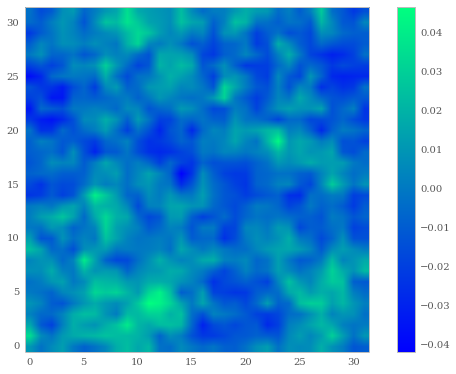

In [44]:
plt.imshow(data, origin='lower', cmap=plt.cm.winter)
plt.colorbar()

This has a lot of small-scale structure in it. We should expect the best fitting GP correlation length to be smallish.

In [8]:
coords = np.array([[i, j] for i in np.linspace(0, 1, data.shape[0])
                  for j in np.linspace(0, 1, data.shape[1])])

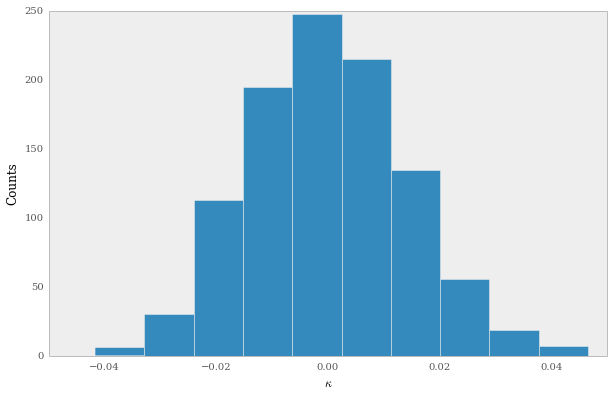

In [49]:
plt.hist(data.ravel())
plt.xlabel(r"$\kappa$")
plt.ylabel("Counts")

In [124]:
#guess0 = [3.0, 2.]
gp = george.GP(np.var(data)*kernels.KappaKappaExpSquaredKernel([0.01,0.01], ndim=2.) + kernels.WhiteKernel(np.std(data)/1000., ndim=2),
               mean=np.mean(data))
gp_cov = gp.get_matrix(coords)

logdet GP cov: (1.0, -7349.0485785878172)


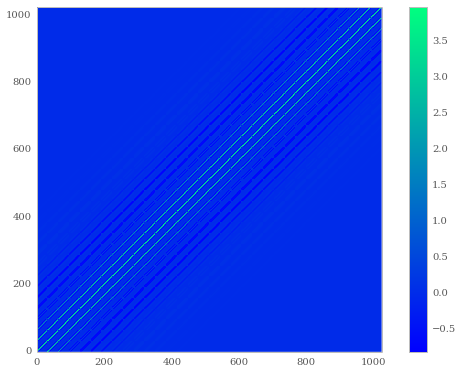

In [125]:
plt.imshow(gp_cov, interpolation='none', origin='lower', cmap=plt.cm.winter)
plt.colorbar()
print("logdet GP cov:", np.linalg.slogdet(gp_cov))

In [126]:
yerr = 1e-6
gp.compute(coords, yerr)

In [127]:
print(gp.lnlikelihood(data.ravel()))

1783.88520672


Sample some convergence fields with this covariance

In [80]:
kappa_samples = gp.sample(size=2)

Look at the residuals between the input and sampled convergence fields. 
We don't expect these to match well because we're just sampling from the prior.
Rather, does the input convergence look like it could have been a sample from the prior?

<matplotlib.colorbar.Colorbar instance at 0x10ff1f758>

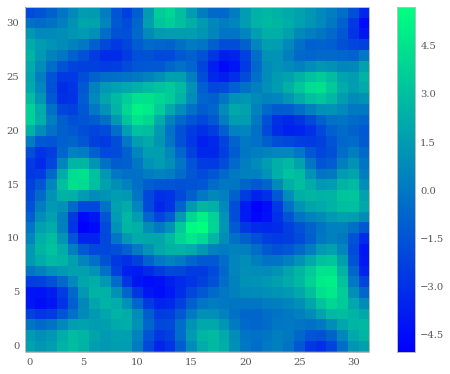

In [81]:
plt.imshow(kappa_samples[0].reshape(32,32) - data, interpolation='none', origin='lower', cmap=plt.cm.winter)
plt.colorbar()

Now let's draw some conditional samples.

In [83]:
print(1./32., 1./8.)

0.03125 0.125


In [95]:
nx = 16
ny = 16
new_coords = np.array([[i, j] for i in np.linspace(0.02, 0.98, nx)
                  for j in np.linspace(0.02, 0.98, ny)])

kappa_cond = gp.sample_conditional(y=data.ravel(), t=new_coords, size=2)

<matplotlib.colorbar.Colorbar instance at 0x10d848170>

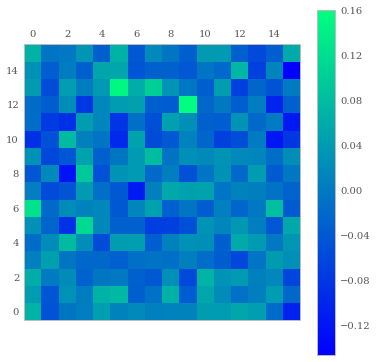

In [97]:
plt.matshow(kappa_cond[0].reshape(nx, ny), interpolation='none', origin='lower', cmap=plt.cm.winter)
plt.colorbar()

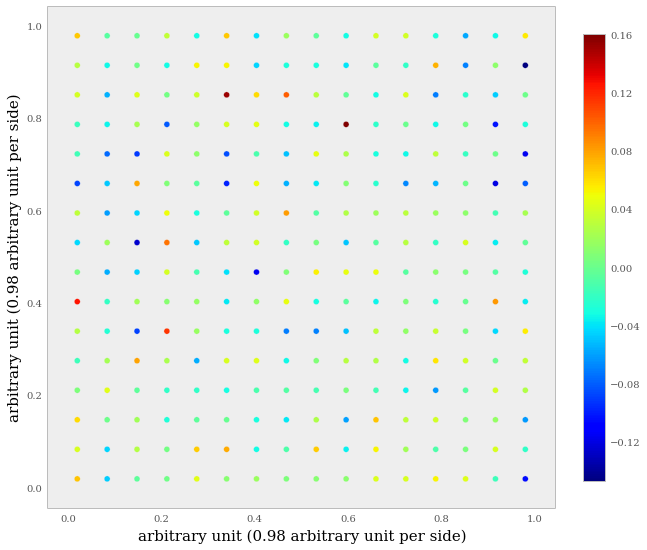

In [103]:
dplot.plot_2D_gp_samples(kappa_cond[0], new_coords, figside=9, range_No=1, kernel_name=r"$\kappa\kappa$")

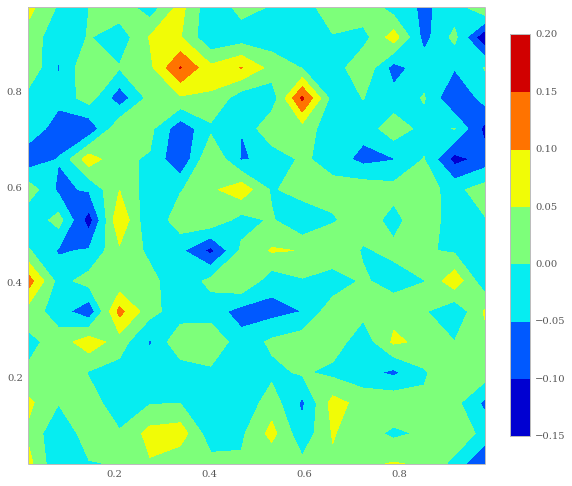

In [104]:
dplot.plot_2D_gp_sample_contour(kappa_cond[0], new_coords, figside=9)

Inferred noise_amp =  0.00375336429994


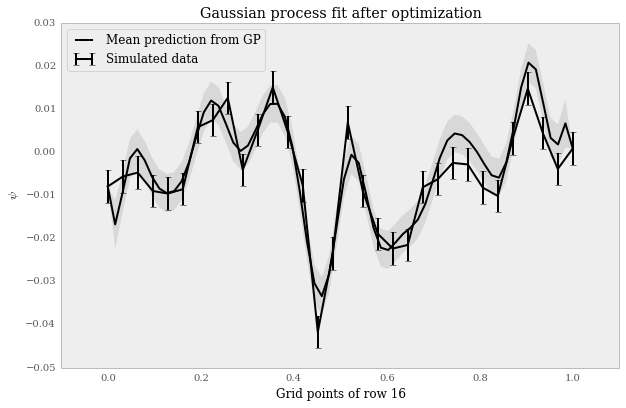

In [128]:
dplot.posterior_predictive_surface_vs_truth(
    gp, coords, data.ravel(), 16, 32, (0,1), factor=2
)

In [60]:
(initial_guess, opt_param) = gp.optimize(coords, data.ravel(), yerr=yerr)
print(opt_param)

KeyboardInterrupt: 

In [20]:
initial_guess = np.log(opt_param["x"])
lnprior_vals = [[-10, 10], [-10, 10]]

NameError: name 'opt_param' is not defined

In [ ]:
initial_guess

array([ 0.09404783, -0.36651292])

In [ ]:
sampler, p0 = sam.fit_gp(initial_guess, data.ravel().copy(), 
                         guess_dev_frac=1e-1,
                         nwalkers=4)  